In [1]:
%matplotlib inline
import nltk
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns


In [2]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt   

In [3]:
#nltk.download('wordnet')

In [4]:
df_train = pd.read_csv('data/training/2018-E-c-En-train.txt', sep="\t")
df_train['tidy_Tweet'] = np.vectorize(remove_pattern)(df_train['Tweet'], "@[\w]*") 
#df_train['tidy_Tweet'] = df_train['tidy_Tweet'].str.replace("[^a-zA-Z#]", " ")
df_train['tidy_Tweet'] = df_train['tidy_Tweet'].str.replace("[^a-zA-Z]", " ")
df_train['tidy_Tweet'] = df_train['tidy_Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

df_train['tidy_Tweet'] = df_train['tidy_Tweet'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in stop_words]))
ps = PorterStemmer()
lmtzr = WordNetLemmatizer()
df_train['tidy_Tweet'] = df_train['tidy_Tweet'].apply(lambda x: ' '.join([lmtzr.lemmatize(w,'v') for w in x.split()]))
#df_train['tidy_Tweet'][:10].to_csv('tidy_Tweet.csv')
print(df_train.shape)
df_train['tidy_Tweet'][:10]

(6838, 14)


0    worry payment problem may never joyce meyer mo...
1                 whatever decide make sure make happy
2    also help majority nfl coach inept some bill b...
3    accept challenge literally even feel exhilarat...
4    roommate okay spell autocorrect terrible first...
5        cute atsu probably shy photos cherry help uwu
6             think humans sense recognize impend doom
7    rooneys fuck untouchable be fuck dreadful depa...
8         pretty depress hit pan favourite highlighter
9    pussy weak hear stfu bitch you get threaten pr...
Name: tidy_Tweet, dtype: object

In [5]:
df_dev = pd.read_csv('data/training/2018-E-c-En-dev.txt', sep="\t")
df_dev['tidy_Tweet'] = np.vectorize(remove_pattern)(df_dev['Tweet'], "@[\w]*") 
#df_train['tidy_Tweet'] = df_train['tidy_Tweet'].str.replace("[^a-zA-Z#]", " ")
df_dev['tidy_Tweet'] = df_dev['tidy_Tweet'].str.replace("[^a-zA-Z]", " ")
df_dev['tidy_Tweet'] = df_dev['tidy_Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df_dev['tidy_Tweet'] = df_dev['tidy_Tweet'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in stop_words]))
ps = PorterStemmer()
lmtzr = WordNetLemmatizer()
df_dev['tidy_Tweet'] = df_dev['tidy_Tweet'].apply(lambda x: ' '.join([lmtzr.lemmatize(w,'v') for w in x.split()]))
print(df_dev.shape)
df_dev['tidy_Tweet'][:10]

(886, 14)


0            hide revenge anger rememberthe time rebut
1                                  make sure smile bro
2    teamchristine tana do provoke tweet shady shit...
3    great start beginners jump auto trade profitab...
4            best friends drive first time car terrify
5    hey field skibbereen give online delivery serv...
6    why emmerdale rob robron first child together ...
7    would like hear podcast go refute entire artic...
8    hear one time intimidate men go explode why gu...
9                                      depression suck
Name: tidy_Tweet, dtype: object

In [6]:
#pip install keras

In [7]:
#pip install tensorflow

In [20]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model, load_model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

In [9]:
X_train = df_train.tidy_Tweet
y_train = df_train.drop(labels = ['ID','Tweet','tidy_Tweet'], axis=1)
X_dev = df_dev.tidy_Tweet
y_dev = df_dev.drop(labels = ['ID','Tweet','tidy_Tweet'], axis=1)
                    
#combine train and dev dataset to a bigger training data
print(X_train.shape, X_dev.shape)
X_train_dev = pd.concat([X_train, X_dev])
#print(type(X_train), type(X_dev))
print(X_train_dev.shape)
#print(newX[:10])


(6838,) (886,)
(7724,)


In [10]:
tokenizer = Tokenizer(num_words=10000)

#tokenizer.fit_on_texts(X_train)
#tokenizer.fit_on_texts(X_test)
 
tokenizer.fit_on_texts(X_train_dev)
 
X_train = tokenizer.texts_to_sequences(X_train)
X_dev = tokenizer.texts_to_sequences(X_dev) #887 line

vocab_size = len(tokenizer.word_index) + 1

maxlen = 150
embed_size = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_dev = pad_sequences(X_dev, padding='post', maxlen=maxlen)
print("vocab_size:", vocab_size)

vocab_size: 11232


In [11]:
X_train.shape

(6838, 150)

In [12]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.twitter.27B.200d.txt', encoding="utf8")
cnt1 = 0
for line in glove_file:
    
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
    if (cnt1 < 10):
        print(cnt1, "word: ", word)
    cnt1 += 1
glove_file.close()

cnt2 = 0
cnt3 = 0
embedding_matrix = zeros((vocab_size, embed_size))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if (cnt2 < 10):
        print(cnt2, "word: ", word, ", index: ", index)
    cnt2 += 1
    if embedding_vector is not None:
        cnt3 += 1
        embedding_matrix[index] = embedding_vector
print(cnt1, cnt2, cnt3)

0 word:  <user>
1 word:  .
2 word:  :
3 word:  rt
4 word:  ,
5 word:  <repeat>
6 word:  <hashtag>
7 word:  <number>
8 word:  <url>
9 word:  !
0 word:  get , index:  1
1 word:  like , index:  2
2 word:  amp , index:  3
3 word:  make , index:  4
4 word:  know , index:  5
5 word:  time , index:  6
6 word:  the , index:  7
7 word:  love , index:  8
8 word:  people , index:  9
9 word:  think , index:  10
1193514 11231 9627


In [13]:
deep_inputs = Input(shape=(None,))

embedding_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], trainable=False)(deep_inputs)
#LSTM_Layer_1 = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer) #128 memory cells, https://keras.io/api/layers/recurrent_layers/lstm/
#LSTM_Layer_1 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
bidirectional_1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
bidirectional_2 = Bidirectional(LSTM(64))(bidirectional_1)
dense_layer_1 = Dense(11, activation='sigmoid')(bidirectional_2)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam')
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

#Old
#deep_inputs = Input(shape=(maxlen,))
deep_inputs = Input(shape=(None,))

embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer) #128 memory cells, https://keras.io/api/layers/recurrent_layers/lstm/
#LSTM_Layer_1 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
dense_layer_1 = Dense(11, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

In [14]:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 200)         2246400   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 11)                1419      
Total params: 2,482,315
Trainable params: 235,915
Non-trainable params: 2,246,400
_________________________________________________________________
None


In [15]:
#pip install pydot

from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [16]:
history = model.fit(X_train, y_train, batch_size=64, epochs=8, verbose=1, validation_split=0.2)

Epoch 1/8
86/86 [==============================] - 19s 224ms/step - loss: 0.4563 - val_loss: 0.3975
Epoch 2/8
86/86 [==============================] - 18s 207ms/step - loss: 0.3855 - val_loss: 0.3710
Epoch 3/8
86/86 [==============================] - 18s 210ms/step - loss: 0.3534 - val_loss: 0.3521
Epoch 4/8
86/86 [==============================] - 18s 212ms/step - loss: 0.3303 - val_loss: 0.3479
Epoch 5/8
86/86 [==============================] - 18s 208ms/step - loss: 0.3129 - val_loss: 0.3389
Epoch 6/8
86/86 [==============================] - 18s 212ms/step - loss: 0.2967 - val_loss: 0.3425
Epoch 7/8
86/86 [==============================] - 18s 214ms/step - loss: 0.2825 - val_loss: 0.3450
Epoch 8/8
86/86 [==============================] - 18s 214ms/step - loss: 0.2713 - val_loss: 0.3479


history = model.fit(X_train, y_train, batch_size=64, epochs=15, verbose=1, validation_split=0.2)

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
#predictions=model.predict([padded_docs_test])
predictions=model.predict(X_dev)
print(predictions.shape)
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_dev, pred, average='micro')
    recall = recall_score(y_dev, pred, average='micro')
    f1 = f1_score(y_dev, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

(886, 11)
Micro-average quality numbers
Precision: 0.4456, Recall: 0.8561, F1-measure: 0.5861
Micro-average quality numbers
Precision: 0.5424, Recall: 0.7612, F1-measure: 0.6334
Micro-average quality numbers
Precision: 0.6195, Recall: 0.6849, F1-measure: 0.6505
Micro-average quality numbers
Precision: 0.6822, Recall: 0.6289, F1-measure: 0.6545
Micro-average quality numbers
Precision: 0.7310, Recall: 0.5835, F1-measure: 0.6490
Micro-average quality numbers
Precision: 0.7751, Recall: 0.5215, F1-measure: 0.6235
Micro-average quality numbers
Precision: 0.8273, Recall: 0.4433, F1-measure: 0.5773
Micro-average quality numbers
Precision: 0.8563, Recall: 0.3503, F1-measure: 0.4972
Micro-average quality numbers
Precision: 0.8996, Recall: 0.2365, F1-measure: 0.3745


In [18]:
def accuracy (y_dev, predictions, size):
    #a=predictions.toarray()
    a=predictions
    b=y_dev.to_numpy()
    U = np.zeros((size,11), dtype = np.int64)
    I = np.zeros((size,11), dtype = np.int64)
    sum=0
    for i in range(0,size):
        for j in range(0,10):
            if a[i][j]==1 or b[i][j]==1:
                U[i][j]=1
    for i in range(0,size):
        for j in range(0,10):
            if a[i][j]==1 and b[i][j]==1:
                I[i][j]=1
    for i in range(0,size):
        if U[i].tolist().count(1) == 0:
            sum = sum + 1
        else:
            sum = sum + I[i].tolist().count(1)/U[i].tolist().count(1)
    return sum/size

(886, 11)
<class 'numpy.ndarray'>
t = 0.05
Accuracy =  0.006772009029345372
F1 =  0.5263574064312071
Hamming loss =  0.3687666735070798
imp =  0.4023119782149123
t = 0.06
Accuracy =  0.012415349887133182
F1 =  0.5416265308930783
Hamming loss =  0.34178124358711265
imp =  0.42128659213873604
t = 0.07
Accuracy =  0.016930022573363433
F1 =  0.554855342308794
Hamming loss =  0.3189000615637185
imp =  0.4372980042280266
t = 0.08
Accuracy =  0.029345372460496615
F1 =  0.5666815012609405
Hamming loss =  0.29971270264723987
imp =  0.45027455301157304
t = 0.09
Accuracy =  0.03837471783295711
F1 =  0.5780914390917459
Hamming loss =  0.28216704288939054
imp =  0.46159527392597344
t = 0.1
Accuracy =  0.04853273137697517
F1 =  0.5860921907175669
Hamming loss =  0.26810999384362816
imp =  0.46889085957934673
t = 0.11
Accuracy =  0.05981941309255079
F1 =  0.595959595959596
Hamming loss =  0.2544633695875231
imp =  0.477293614962915
t = 0.12
Accuracy =  0.06659142212189616
F1 =  0.6035404141616567
Ham

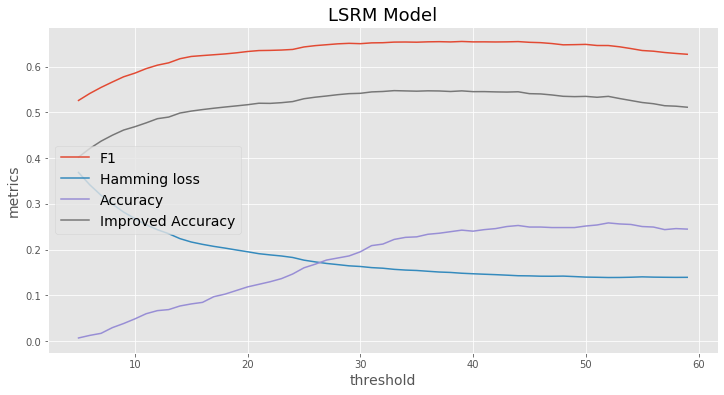

In [19]:
from sklearn.metrics import hamming_loss
#cc_classifier = ClassifierChain(SVC(kernel='linear', probability=True))
#cc_classifier.fit(x_train, y_train)
#cc_predictions_proba = cc_classifier.predict_proba(x_dev)

predictions=model.predict(X_dev)
print(predictions.shape)
print(type(predictions))
#for plotting metrics as a function of threashold
th = []
f = []
ham = []
ac = []
imp = []
for t in range (5,60): # threshold value
    y_pred_new = (predictions >= t/100).astype(int)
    print("t =" ,t/100)
    print("Accuracy = ",accuracy_score(y_dev,y_pred_new))
    print("F1 = ",f1_score(y_dev,y_pred_new, average="micro"))
    print("Hamming loss = ",hamming_loss(y_dev,y_pred_new))
    print("imp = ",accuracy(y_dev,y_pred_new, X_dev.shape[0]))
    th.append(t)
    ac.append(accuracy_score(y_dev,y_pred_new))
    f.append(f1_score(y_dev,y_pred_new, average="micro"))
    ham.append(hamming_loss(y_dev,y_pred_new))
    imp.append(accuracy(y_dev,y_pred_new, X_dev.shape[0]))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, ham)
    plt.plot(th, ac)
    plt.plot(th, imp)
    plt.legend(['F1', 'Hamming loss', 'Accuracy', 'Improved Accuracy'], loc='center left', fontsize = 14)
    plt.ylabel("metrics", fontsize = 14)
    plt.xlabel("threshold", fontsize = 14)
    plt.title("LSRM Model", fontsize = 18)
plt.show()


In [21]:
model.save('LSTM_model_ver1.h5')